In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
import seaborn as sns

In [2]:
# adult.data & adult.test are downloaded from
# https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
# https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
# respectively
train_set = pd.read_csv('adult.data', header = None)
test_set = pd.read_csv('adult.test' , skiprows = 1, header = None) 
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class'] 
train_set.columns = col_labels 
test_set.columns = col_labels

In [3]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing  = test_set.replace(' ?', np.nan).dropna()

test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})
test_nomissing.wage_class.unique()
train_nomissing.wage_class.unique()

combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0)

In [4]:
for feature in combined_set.columns: 
    if combined_set[feature].dtype == 'object':
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes

final_train = combined_set[:train_nomissing.shape[0]]
final_test = combined_set[train_nomissing.shape[0]:]

y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [6]:
from sklearn.grid_search import GridSearchCV

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy
optimized_GBM.fit(final_train, y_train)

C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Deepak\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [7]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 432)

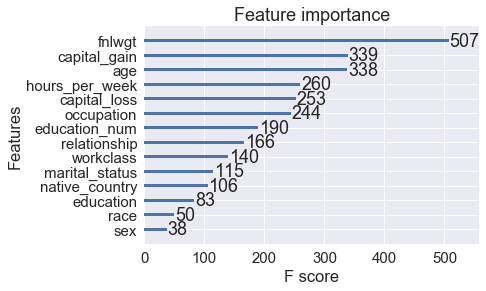

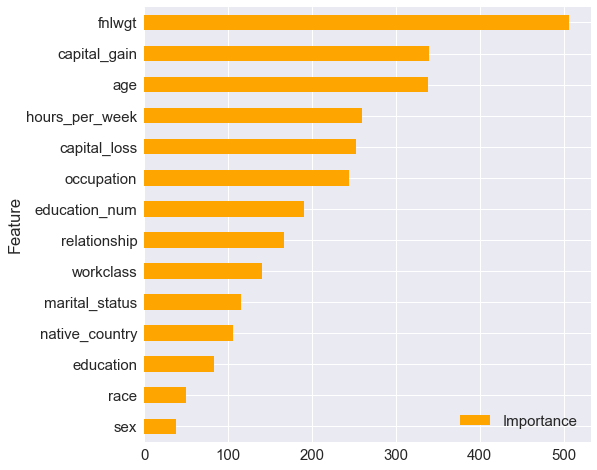

In [9]:
import seaborn as sns
sns.set(font_scale = 1.5)

xgb.plot_importance(final_gb)

importances = final_gb.get_fscore()

importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

testdmat = xgb.DMatrix(final_test)

In [10]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat

y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.8686586985391767, 0.13134130146082335)